# Simulating the Motion of an Optically Trapped Particle

This notebook provides you with a complete code example that loads a set of precalculated optical forces acting on a microsphere held by an optical tweezer and uses it to train a dense neural network to predict the optical forces as a function of the particle position.

## Loading the Data

In [2]:
from os import path, system

if not path.exists("optical_forces_dataset"):
    system("git clone https://github.com/DeepTrackAI/optical_forces_dataset")

Cloning into 'optical_forces_dataset'...


### Loading the Theoretical Optical Forces

In [5]:
import numpy as np

fz_vs_z_path = path.join("optical_forces_dataset", "fz_vs_z_theory.txt")

data_theory = [] 
with open(fz_vs_z_path, "r") as file:
	for line in file:
		row = []
		for numbers in line.split(","):
			row.append(float(numbers))
		data_theory.append(row)
data_theory = np.array(data_theory)

z_theory = data_theory[:, 0]
fz_theory = data_theory[:, 1] * 1e3  # Conversion from pN to fN.

print(f"Theory: {len(z_theory)} positions and {len(fz_theory)} forces")

Theory: 101 positions and 101 forces


### Loading the Geometrical Optics Optical Forces

In [6]:
xyz_go = np.load(path.join("optical_forces_dataset", "xyz_go_100rays.npy"))
z_go = xyz_go[50, 50, :, 2]

fxyz_go = np.load(path.join("optical_forces_dataset", "fxyz_go_100rays.npy"))
fz_go = fxyz_go[50, 50, :, 2]

print(f"GO: {len(z_go)} positions and {len(fz_go)} forces")

GO: 101 positions and 101 forces


### Comparing the Theoretical and Geometrical Optics Optical Forces 

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/var/folders/nk/vplzgbvj0w1gpgk5h_j226480000gp/T/ipykernel_77488/3315551583.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$z$ [$\mu$m]", fontsize=16); plt.ylabel("$F_z$ [fN]", fontsize=16)


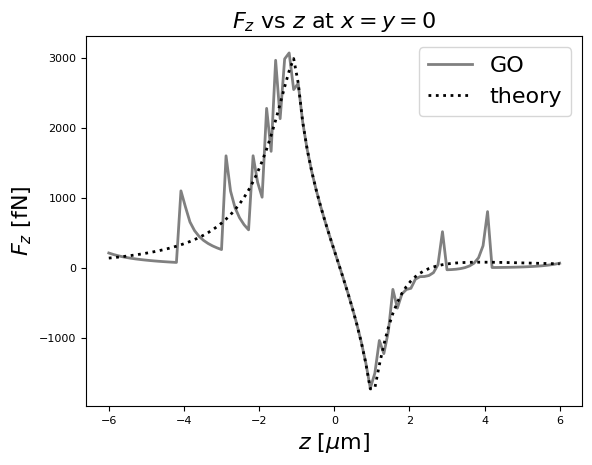

In [7]:
import matplotlib.pyplot as plt

plt.plot(z_go, fz_go, c="gray", linewidth=2, label="GO")
plt.plot(z_theory, fz_theory, c="k", linewidth=2, linestyle=":", label="theory")
plt.title("$F_z$ vs $z$ at $x=y=0$", fontsize=16); plt.legend(fontsize=16)
plt.xlabel("$z$ [$\mu$m]", fontsize=16); plt.ylabel("$F_z$ [fN]", fontsize=16)
plt.tick_params(axis="both", which="major", labelsize=8)
plt.show()

## Loading the Training Data

The training data are contained in the files in the directory `sphere_100rays`. There are 101 files with names `force_grid_3D=1.txt`, `force_grid_3D=2.txt`, and so on. Each row in these files consists of eight numbers with the following format: $[R, n_{\rm p}, x, y, z, f_{\rm x}, f_{\rm y}, f_{\rm z}]$, where $R \equiv 1^{−6}\,{\rm m}$ is the particle radius, $n_{\rm p} \equiv 1.5$ is its refractive index, $(x,y,z)$ are its position (in meters), and $(f_{\rm x}, f_{\rm y}, f_{\rm z})$ are its force (in Newtons). 

Write a function to load a data file with optical forces ...

In [13]:
def load_data_file(filename):
    """Load a data file with optical forces."""
    data = []
    with open(filename, "r") as file:
        for line in file:
            row, count = [], 0
            for number in line.split():
                if 2 <= count <= 4:
                    row.append(float(number) * 1e6)  # From m to um.
                elif 5 <= count <= 7:
                    row.append(float(number) * 1e15)  # From N to fN.
                count += 1
            data.append(row)
    return np.array(data)

... and use it to load all data of the optical forces.

In [14]:
data = np.empty((0, 6))
for i in range (1, 102):
    filename = path.join("optical_forces_dataset", "sphere_100rays", 
                            f"force_grid_3D={i}.txt")
    data = np.append(data, load_data_file(filename), axis=0)
    
    
print(f"{np.shape(data)[0]} data points with {np.shape(data)[1]} variables")

1030301 data points with 6 variables


### Splitting the Data into Training and Validation Datasets

In [18]:
train_split = .80
train_size = int(len(data) * train_split)

np.random.shuffle(data)  # In-place shuffle.

data_train, data_val = data[:train_size], data[train_size:]
xyz_train, fxyz_train = data_train[:, :3], data_train[:, 3:]
xyz_val, fxyz_val = data_val[:, :3], data_val[:, 3:]

print(f"{len(xyz_train)} training datapoints")
print(f"{len(xyz_val)} validation datapoints")

824240 training datapoints
206061 validation datapoints


## Implementing the Neural Network

Define the neural network ...

In [19]:
import deeplay as dl

mlp_model = dl.MultiLayerPerceptron(in_features=3, 
    hidden_features=[256, 256, 256], out_features=3).create()

print(mlp_model)
print(sum(p.numel() for p in mlp_model.parameters()))

MultiLayerPerceptron(
  (blocks): LayerList(
    (0): LinearBlock(
      (layer): Linear(in_features=3, out_features=256, bias=True)
      (activation): ReLU()
    )
    (1-2): 2 x LinearBlock(
      (layer): Linear(in_features=256, out_features=256, bias=True)
      (activation): ReLU()
    )
    (3): LinearBlock(
      (layer): Linear(in_features=256, out_features=3, bias=True)
      (activation): Identity()
    )
  )
)
133379


... and compile it.

In [20]:
from torch.nn import MSELoss
from torchmetrics import MeanAbsoluteError

regressor = dl.Regressor(mlp_model, loss=MSELoss(), optimizer=dl.Adam(), 
    metrics=[MeanAbsoluteError()]).create()

print(regressor)

Regressor(
  (loss): MSELoss()
  (optimizer): Adam[Adam]()
  (train_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=test
  )
  (model): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LinearBlock(
        (layer): Linear(in_features=3, out_features=256, bias=True)
        (activation): ReLU()
      )
      (1-2): 2 x LinearBlock(
        (layer): Linear(in_features=256, out_features=256, bias=True)
        (activation): ReLU()
      )
      (3): LinearBlock(
        (layer): Linear(in_features=256, out_features=3, bias=True)
        (activation): Identity()
      )
    )
  )
)


### Implementing Data Loaders

Implement a custom dataset ...

In [21]:
from torch.utils.data import Dataset

class GODataset(Dataset):
    """Geometrical optics dataset."""

    def __init__(self, r, f):
        """Initialize dataset."""
        self.r, self.f = r, f

    def __len__(self):
        """Return number of position-force couples."""
        return len(self.r)

    def __getitem__(self, i):
        """Get next position-force couple."""
        return (self.r[i].astype(np.float32), self.f[i].astype(np.float32))

... and set up the data loaders for the training and validation data.

In [22]:
train_dataset = GODataset(xyz_train, fxyz_train)
train_dataloader = dl.DataLoader(train_dataset, batch_size=1024)

val_dataset = GODataset(xyz_val, fxyz_val)
val_dataloader = dl.DataLoader(val_dataset, batch_size=1024)

## Training the Neural Network

In [24]:
from lightning.pytorch.loggers import CSVLogger

trainer = dl.Trainer(max_epochs=100, accelerator="auto", 
    logger=CSVLogger("logs", name="regressor"), log_every_n_steps=20)
trainer.fit(regressor, train_dataloader, val_dataloader)

Missing logger folder: logs/regressor


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                 ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss          │ MSELoss              │      0 │
│ 1 │ train_metrics │ MetricCollection     │      0 │
│ 2 │ val_metrics   │ MetricCollection     │      0 │
│ 3 │ test_metrics  │ MetricCollection     │      0 │
│ 4 │ model         │ MultiLayerPerceptron │  133 K │
│ 5 │ optimizer     │ Adam                 │      0 │
└───┴───────────────┴──────────────────────┴────────┘

Trainable params: 133 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 133 K                                                                                                
Total estimated model params size (MB): 0

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/py
torch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to
improve performance.

... extract the training metrics ...

In [25]:
import pandas as pd

version = 0
logs = pd.read_csv(path.join("logs", "regressor", f"version_{version}", 
                                "metrics.csv"))

# Group by epoch and extract train loss and MAE.
train_epoch = logs[logs.train_loss_epoch.notnull()].epoch
train_loss = logs[logs.train_loss_epoch.notnull()].train_loss_epoch
train_mae = logs[logs.trainMeanAbsoluteError_epoch.notnull()] \
    .trainMeanAbsoluteError_epoch

# Group by epoch and extract val loss and MAE.
val_epoch = logs[logs.val_loss_epoch.notnull()].epoch
val_loss = logs[logs.val_loss_epoch.notnull()].val_loss_epoch
val_mae = logs[logs.valMeanAbsoluteError_epoch.notnull()] \
    .valMeanAbsoluteError_epoch

... and plot the training history.

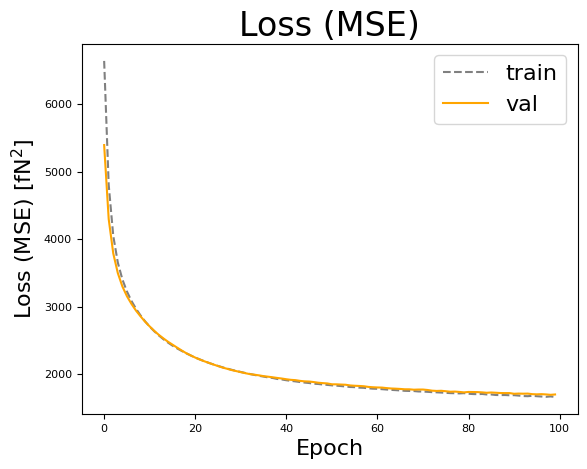

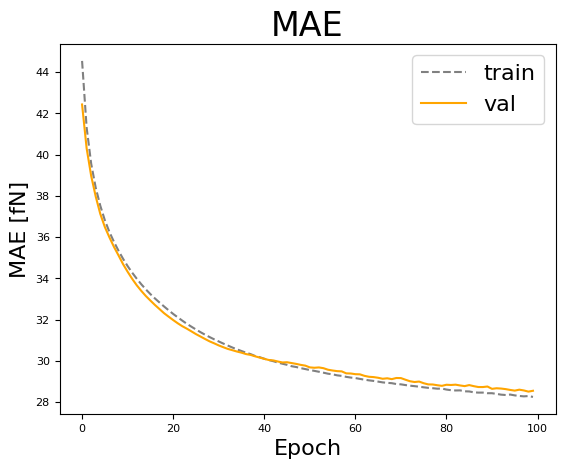

In [26]:
plt.plot(val_epoch, train_loss, label="train", c="gray", linestyle="--")
plt.plot(val_epoch, val_loss, label="val", c="orange")
plt.title("Loss (MSE)", fontsize=24); plt.legend(fontsize=16)
plt.xlabel("Epoch", fontsize=16); plt.ylabel("Loss (MSE) [fN$^2$]", fontsize=16)
plt.tick_params(axis="both", which="major", labelsize=8)
plt.show()

plt.plot(val_epoch, train_mae, label="train", c="gray", linestyle="--")
plt.plot(val_epoch, val_mae, label="val", c="orange")
plt.title("MAE", fontsize=24); plt.legend(fontsize=16)
plt.xlabel("Epoch", fontsize=16); plt.ylabel("MAE [fN]", fontsize=16)
plt.tick_params(axis="both", which="major", labelsize=8)
plt.show()

## Evaluating the Neural Network Performance

Calculate the neural network predictions ...

In [27]:
import torch

positions_nn = torch.zeros((z_theory.shape[0], 3))
positions_nn[:, 2] = torch.from_numpy(z_theory)
positions_nn = positions_nn.to(regressor.device)

forces_nn = regressor(positions_nn).cpu().detach().numpy()
fz_nn = forces_nn[:, 2]

... and plot the comparison of theory, geometrical optics (GO) calculations, and neural network (NN) predictions.

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
/var/folders/nk/vplzgbvj0w1gpgk5h_j226480000gp/T/ipykernel_77488/368027701.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$z$ [$\mu$m]", fontsize=16); plt.ylabel("$F_z$ [fN]", fontsize=16)


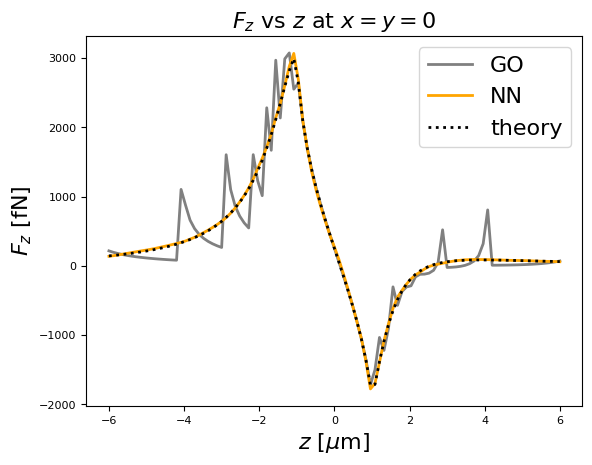

In [28]:
plt.plot(z_go, fz_go, c="gray", linewidth=2, label="GO")
plt.plot(z_theory, fz_nn, c="orange", linewidth=2, label="NN")
plt.plot(z_theory, fz_theory, c="k", linewidth=2, linestyle=":", label="theory")
plt.title("$F_z$ vs $z$ at $x=y=0$", fontsize=16); plt.legend(fontsize=16)
plt.xlabel("$z$ [$\mu$m]", fontsize=16); plt.ylabel("$F_z$ [fN]", fontsize=16)
plt.tick_params(axis="both", which="major", labelsize=8)
plt.show()